# 2603655_DataAcquisition

## Week5 20240903

---
* Author:  [Yuttapong Mahasittiwat](mailto:khala1391@gmail.com)
* Technologist | Data Modeler | Data Analyst
* [YouTube](https://www.youtube.com/khala1391)
* [LinkedIn](https://www.linkedin.com/in/yuttapong-m/)
---

In [3]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import altair as alt
from scipy import stats
print("pandas version :",pd.__version__)
print("numpy version :",np.__version__)
print("matplotlib version :",mpl.__version__)
print("seaborn version :",sns.__version__)
print("altair version :",alt.__version__)

pandas version : 2.2.1
numpy version : 1.26.4
matplotlib version : 3.8.4
seaborn version : 0.13.2
altair version : 5.4.0


In [9]:
df = pd.read_csv('data/thaisky_airways_bookings.csv',
                 parse_dates=['booking_date', 'flight_date'],
                 # index_col=['datetime']
                )
# df.drop(columns=['id'],inplace=True)
# df['timestamp']=pd.to_datetime(df['timestamp'],unit='s')
df['days_before_flight'] = (df['flight_date']-df['booking_date']).dt.days
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   booking_date        50000 non-null  datetime64[ns]
 1   flight_date         50000 non-null  datetime64[ns]
 2   price               50000 non-null  float64       
 3   days_before_flight  50000 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 1.5 MB


,booking_date,flight_date,price,days_before_flight
0,2022-06-24,2023-01-01,7129.925638,191
1,2022-06-24,2023-01-01,7129.925638,191
2,2022-07-05,2023-01-08,6800.089944,187


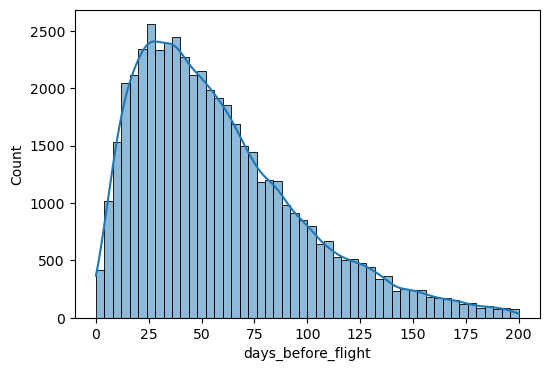

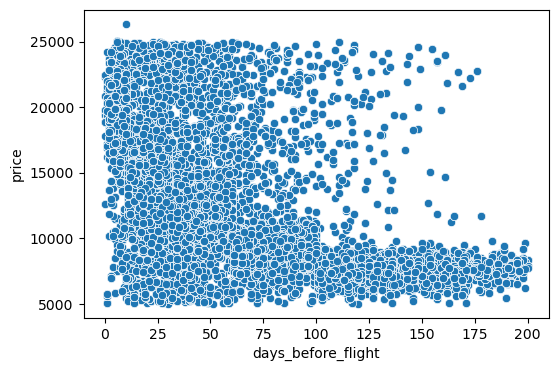

In [21]:
plt.figure(figsize=(6,4))
sns.histplot(df['days_before_flight'],bins=50,kde=True)
plt.show()


plt.figure(figsize=(6,4))
sns.scatterplot(x='days_before_flight',y='price',data=df)
plt.show()

### method for checking outlier

#### IQR

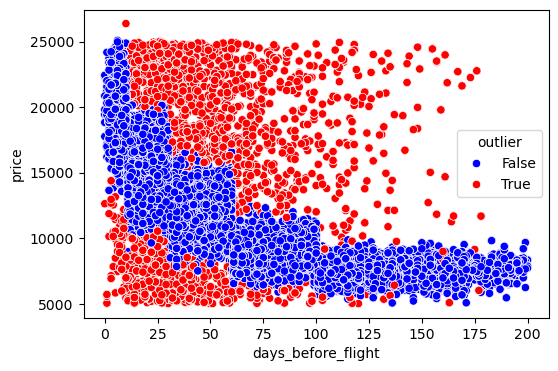

In [33]:
df['outlier'] = False

for days_before_flight in df['days_before_flight'].unique():
    df_temp = df[df['days_before_flight']==days_before_flight]

    Q1 = df_temp['price'].quantile(0.25)
    Q3 = df_temp['price'].quantile(0.75)

    IQR = Q3 -Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    mask = (df_temp['price']<lower_bound) | (df_temp['price']>upper_bound)
    outliers = df_temp[mask].copy()

    df.loc[outliers.index,'outlier'] = True

fig, ax= plt.subplots(figsize=(6,4))
color_palette = {False:'blue', True: 'red'}
sns.scatterplot(x='days_before_flight', y='price',hue='outlier', palette=color_palette, data=df,ax=ax)
plt.show()

#### Z-score 

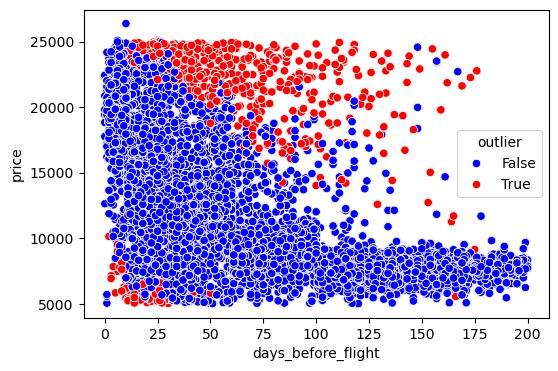

In [40]:
df['outlier'] = False

for days_before_flight in df['days_before_flight'].unique():
    df_temp = df[df['days_before_flight']==days_before_flight]

    mean_price = df_temp['price'].mean()
    std_price = df_temp['price'].std()

    z_scores = (df_temp['price']-mean_price)/std_price

    outliers =  df_temp[abs(z_scores)>3].copy()
    df.loc[outliers.index,'outlier']= True

    
    df.loc[outliers.index,'outlier'] = True

fig, ax= plt.subplots(figsize=(6,4))
color_palette = {False:'blue', True: 'red'}
sns.scatterplot(x='days_before_flight', y='price',hue='outlier', palette=color_palette, data=df,ax=ax)
plt.show()

#### DBSCAN

In [54]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

**eps**: float, default=0.5 <br>
The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.
- higher >> keep more data point >> less outlier datapoint

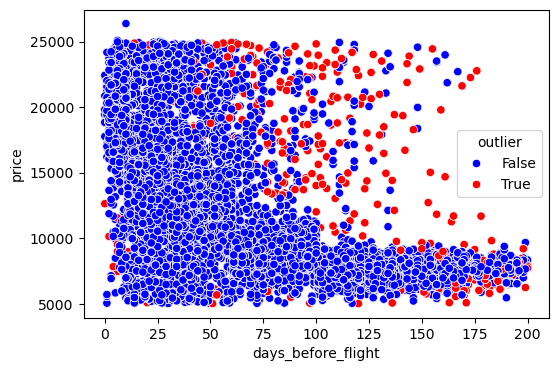

In [163]:
df['outlier'] = False

for days_before_flight in df['days_before_flight'].unique():
    df_temp = df[df['days_before_flight']==days_before_flight]

    X = df_temp[['price']].values
    X =StandardScaler().fit_transform(X)

    dbscan = DBSCAN(eps=0.1, min_samples=5)  # hyperparameter
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # hyperparameter  lower outlier
    clusters = dbscan.fit_predict(X)
    outliers = df_temp[clusters == -1].copy()
    
    df.loc[outliers.index,'outlier'] = True

fig, ax= plt.subplots(figsize=(6,4))
color_palette = {False:'blue', True: 'red'}
sns.scatterplot(x='days_before_flight', y='price',hue='outlier', palette=color_palette, data=df,ax=ax)
plt.show()

#### Isolation Forest 

In [180]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

**contamination** ‘auto’ or float, default=’auto’<br>
The amount of contamination of the data set, i.e. the proportion of outliers in the data set. Used when fitting to define the threshold on the scores of the samples.

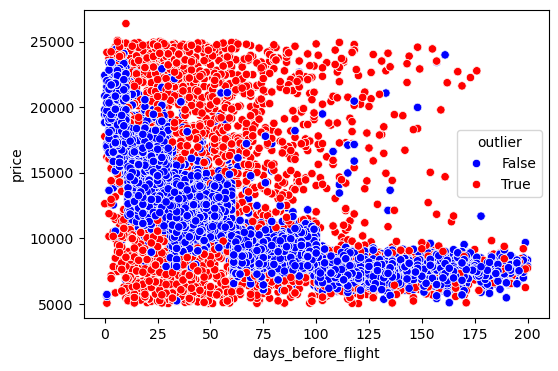

In [182]:
df['outlier'] = False

for days_before_flight in df['days_before_flight'].unique():
    df_temp = df[df['days_before_flight']==days_before_flight]

    X = df_temp[['price']].values
    X =StandardScaler().fit_transform(X)

    iso_forest =  IsolationForest(contamination=0.1, random_state=42)
    # iso_forest =  IsolationForest(contamination=0.5, random_state=42)  # hyperparameter : more outlier
    outlier_labels = iso_forest.fit_predict(X)

    outliers = df_temp[outlier_labels== -1].copy()
    df.loc[outliers.index,'outlier'] = True

fig, ax= plt.subplots(figsize=(6,4))
color_palette = {False:'blue', True: 'red'}
sns.scatterplot(x='days_before_flight', y='price',hue='outlier', palette=color_palette, data=df,ax=ax)
plt.show()

### Chart for outlier

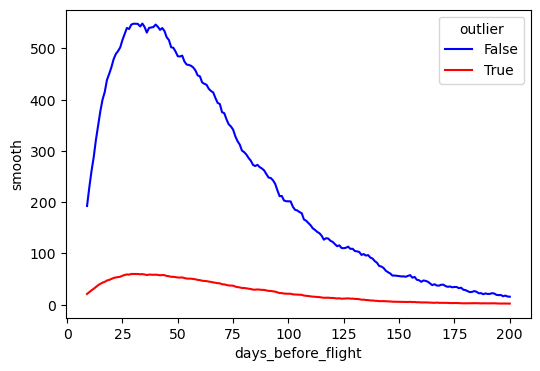

In [228]:
fig,ax= plt.subplots(figsize=(6,4))
outlier_count=df.groupby('days_before_flight')['outlier'].value_counts().reset_index()

# outlier_count

# sns.lineplot(x='days_before_flight',y='count',hue='outlier',palette=color_palette, ax=ax, data=outlier_count)


# line smoothing
outlier_count.sort_values(by='days_before_flight',inplace=True)
outlier_count.loc[outlier_count['outlier'] == False,'smooth'] = \
   outlier_count[outlier_count['outlier'] == False]['count'].rolling(window=10).mean()
outlier_count.loc[outlier_count['outlier'] == True,'smooth'] = \
   outlier_count[outlier_count['outlier'] == True]['count'].rolling(window=10).mean()
sns.lineplot(x='days_before_flight', y='smooth', hue='outlier', data=outlier_count, palette=color_palette,ax=ax)

plt.show()

**result**: 
- shape incline with same trend with FALSE >> outlier
- otherwise: error

### Chart for non-outlier

#### Trimming

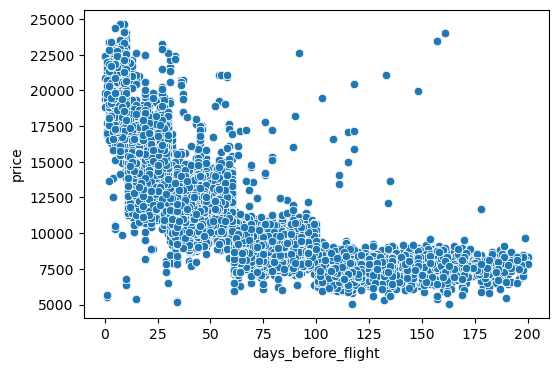

<class 'pandas.core.frame.DataFrame'>
Index: 45177 entries, 0 to 49998
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   booking_date        45177 non-null  datetime64[ns]
 1   flight_date         45177 non-null  datetime64[ns]
 2   price               45177 non-null  float64       
 3   days_before_flight  45177 non-null  int64         
 4   outlier             45177 non-null  bool          
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1)
memory usage: 1.8 MB


In [222]:
# Trimming/ Removing
fig, ax= plt.subplots(figsize=(6,4))
df_clean_outlier = df[df['outlier']== False].copy()
sns.scatterplot(x='days_before_flight', y='price',data=df_clean_outlier,ax=ax)
plt.show()

df_clean_outlier.info()

#### Winsorization
- Winsorization is essentially similar to imputing, but instead of imputing extreme values with mean, median, mode, min or max values, we input those outliers with our chosen percentile.
- winsorization is subset of clipping at certain percentile
- clipping is superset

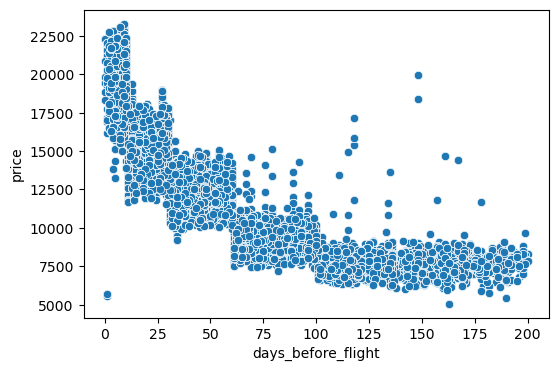

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   booking_date        50000 non-null  datetime64[ns]
 1   flight_date         50000 non-null  datetime64[ns]
 2   price               50000 non-null  float64       
 3   days_before_flight  50000 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 1.5 MB


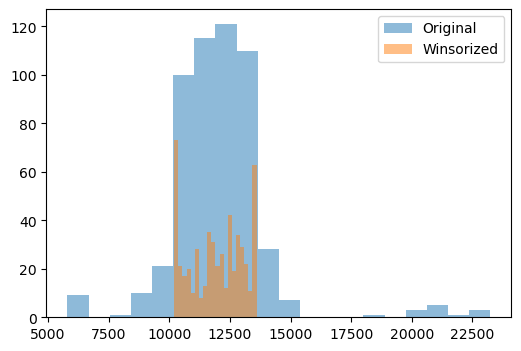

In [225]:
# winsorization /clipping / capping  >>> recode to boundary
df_clean_outlier =df.copy()
# df_clean_outlier.info()
df_clean_outlier.drop(columns=['outlier'], inplace=True)

# percentile target from outlier analysis
lower_percentile = 0.1   
upper_percentile = 0.9

for days_before_flight in df_clean_outlier['days_before_flight'].unique():
    mask = df_clean_outlier['days_before_flight'] == days_before_flight

    lower =  df_clean_outlier[mask]['price'].quantile(lower_percentile)
    upper =  df_clean_outlier[mask]['price'].quantile(upper_percentile)
    
    df_clean_outlier.loc[mask,'price'] = df_clean_outlier[mask]['price'].clip(lower, upper)


fig, ax= plt.subplots(figsize=(6,4))
sns.scatterplot(x='days_before_flight', y='price',data=df_clean_outlier,ax=ax)
plt.show()
df_clean_outlier.info()

plt.figure(figsize=(6,4))
days_before_flight =50
before = df[df['days_before_flight']== days_before_flight]
after = df_clean_outlier[df_clean_outlier['days_before_flight']== days_before_flight]

plt.hist(before['price'], bins=20, alpha=0.5, label='Original')
plt.hist(after['price'], bins=20, alpha=0.5, label='Winsorized')
plt.legend()
plt.show()